In [11]:
import sys
sys.path.append('..')
sys.path.append('../..')

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle
from simulation_utils import run_std_approach
from DataGenerator import DataGenerator
from constants_sim import RANDOM_SEED, PARAMS

In [12]:
dg = DataGenerator(random_seed=RANDOM_SEED)
X_train, y_train, X_test, y_test, y_test_no_coi, res_proportion, coefs, res_coefs = dg.generate_linear_data(**PARAMS)

fig_name = f'stdapp_lin_{PARAMS["effective_rank"]}rank_{PARAMS["n_common"]}common_{PARAMS["noise"]}noise_{PARAMS["n_informative"]}_\
informative_res_coef{PARAMS["res_coef_value"]}_gt_coef{PARAMS["gt_coef_value"]}'
fig_save_path = f'../../../sent/simulated/leave_out/figure/{fig_name}.png'

#### Select predictors (i.e., model knowledge)

In [13]:
# the empty series will yield and empty index which is needed in the loops below
splits_gt = [pd.Series([])] + np.array_split(coefs[:PARAMS["n_informative"]], 3)
splits_res =  [pd.Series([])] + np.array_split(res_coefs[-PARAMS["n_informative"]:], 3)
if PARAMS['n_common'] > 0:
    splits_commons = [pd.Series([])] + np.array_split(coefs[PARAMS["n_informative"]:PARAMS["n_informative"]+PARAMS['n_common']], 3)
else:
    splits_commons = [pd.Series([])]

X_train_reds = []
X_test_reds = []
dropped_cols = []
gt_inds = []
for i in range(len(splits_gt)):
    gt_inds.append(splits_gt[i].index)
    res_inds = []
    for j in range(len(splits_res)):
        res_inds.append(splits_res[j].index)
        common_inds = []
        for k in range(len(splits_commons)):
            common_inds.append(splits_commons[k].index)
            ids = res_inds + common_inds + gt_inds
            ids = [str(x) for x in np.concatenate([x.values for x in ids])]
            dropped_cols.append(len(ids))
            X_test_reds.append( 
            X_test.drop(columns=ids, errors='ignore')
            )
            X_train_reds.append( 
            X_train.drop(columns=ids, errors='ignore')
            )

/Users/cbirkenbihl/git/Cog_resilience/.conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [14]:
results_gt = [run_std_approach(X_train_reds[i], y_train, X_test_reds[i], y_test) for i in range(len(X_test_reds))]
r2_gt = [run_std_approach(X_train_reds[i], y_train, X_test_reds[i], y_test, 
                          r2_target=y_test_no_coi) for i in range(len(X_test_reds))]
r2_res = [run_std_approach(X_train_reds[i], y_train, X_test_reds[i], y_test, 
                           r2_target=res_proportion) for i in range(len(X_test_reds))]

pickle.dump([results_gt, r2_gt, r2_res], open(f'../../../sent/simulated/leave_out/pickles/{fig_name}.p', 'wb'))

In [15]:
results_gt, r2_gt, r2_res = pickle.load(open(f'../../../sent/simulated/leave_out/pickles/{fig_name}.p', 'rb'))

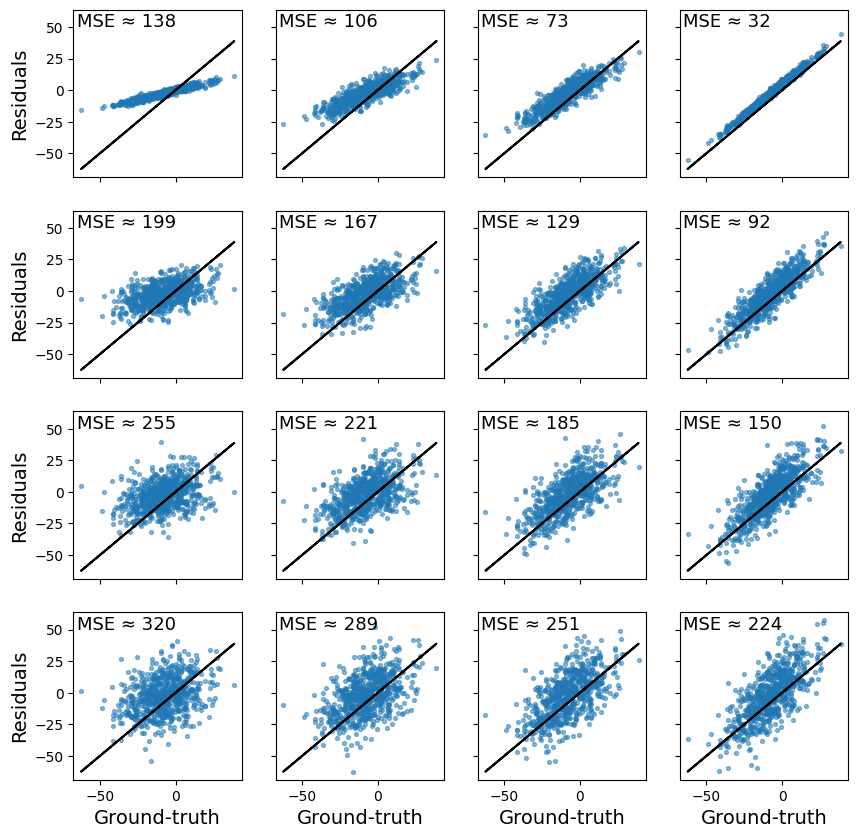

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
# plt.suptitle("Simulation results for linear assumption on gt and resilience", fontsize=14, y=0.94)

# for (results_std_app, _), r2gt, r2res, ax in zip(results_gt, r2_gt, r2_res, axes.flatten()):
for (results_std_app, _), ax in zip(results_gt, axes.flatten()):
    # ax.set_title(f"gt: {r2gt.round(2)}, res: {r2res.round(2)}")
    ax.scatter(res_proportion, results_std_app["Residual"], alpha=0.5, s=8)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"MSE ≈ {mean_squared_error(res_proportion, results_std_app['Residual']):.0f}", 
                    ha='left', va='top', transform=ax.transAxes, fontsize=13)

for ax in axes[:, 0]:
    ax.set_ylabel("Residuals", fontsize=14)
for ax in axes[-1]:
    ax.set_xlabel("Ground-truth", fontsize=14)
plt.savefig(fig_save_path, dpi=300, bbox_inches='tight')


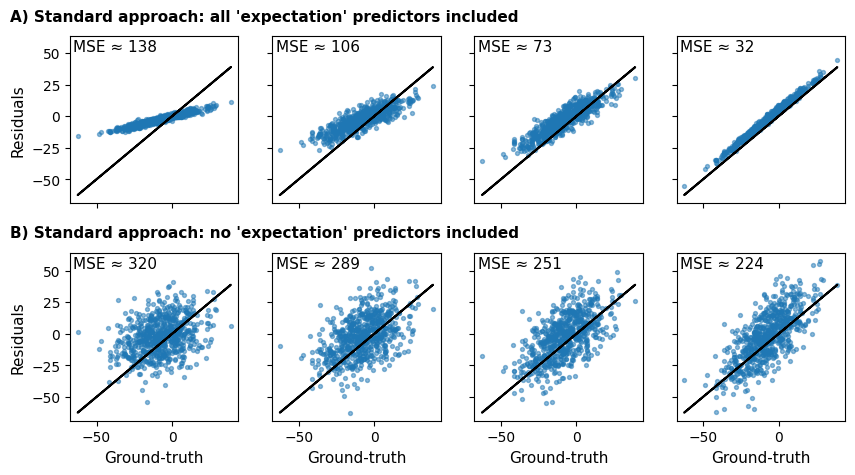

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
# plt.suptitle("Simulation results for linear assumption on gt and resilience", fontsize=14, y=0.94)

for i, ax in enumerate(axes.flatten()[:4]):
    (results_std_app, r2gt) = results_gt[i]
    # ax.set_title(f"gt: {np.round(r2gt[0], 2)}")
    ax.scatter(res_proportion, results_std_app["Residual"], alpha=0.5, s=8)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"MSE ≈ {mean_squared_error(res_proportion, results_std_app['Residual']):.0f}", 
                    ha='left', va='top', transform=ax.transAxes, fontsize=11)
    
for i, ax in enumerate(axes.flatten()[4:]):
    (results_std_app, r2gt) = results_gt[(-4+i)]
    # ax.set_title(f"gt: {np.round(r2gt[0], 2)}")
    ax.scatter(res_proportion, results_std_app["Residual"], alpha=0.5, s=8)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"MSE ≈ {mean_squared_error(res_proportion, results_std_app['Residual']):.0f}", 
                    ha='left', va='top', transform=ax.transAxes, fontsize=11)

plt.figtext(0.065, 0.933, "A) Standard approach: all 'expectation' predictors included", ha="left", va="top", weight='bold', fontsize=11)
plt.figtext(0.065, 0.5, "B) Standard approach: no 'expectation' predictors included", ha="left", va="top", weight='bold', fontsize=11)
plt.subplots_adjust(hspace = 0.3)

for ax in axes[:, 0]:
    ax.set_ylabel("Residuals", fontsize=11)
for ax in axes[-1]:
    ax.set_xlabel("Ground-truth", fontsize=11)
# plt.savefig(fig_save_path, dpi=300, bbox_inches='tight')